# Exploratory Data Analysis

## Variable Exploration 
As it stands, our master USA census data has 278 columns
<br>
That is way too many variable that can cloud our model
<br>
Let's break them down to only the most useful variables 

In [1]:
#these column names don't mean very much to us right now 
##we will a look at variables by mapping encoded column names to label

import pandas as pd

p_file = "../1_Raw_Data/data_persons_us_1yr/psam_pus_master.csv"
all_headers_persons = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Number of columns:", len(all_headers_persons))
print("First 20 columns:", all_headers_persons[:20])
print("Last 10 columns:", all_headers_persons[-10:])

Number of columns: 278
First 20 columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM']
Last 10 columns: ['PWGTP72', 'PWGTP73', 'PWGTP74', 'PWGTP75', 'PWGTP76', 'PWGTP77', 'PWGTP78', 'PWGTP79', 'PWGTP80', 'year']


In [2]:
import pandas as pd
import requests
import json

# 1) get column names
p_file = "../1_Raw_Data/data_persons_us_1yr/psam_pus_master.csv"
cols = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Columns in file:", len(cols))
print("Example columns:", cols[:12])

# 2) fetch Census metadata dictionary
url = "https://api.census.gov/data/2023/acs/acs5/pums/variables.json"
meta = requests.get(url)
meta.raise_for_status()
vardict = meta.json()["variables"]

# 3) map each column -> explanation
rows = []
for c in cols:
    info = vardict.get(c, {})
    values_obj = info.get("values")
    rows.append({
        "column": c,
        "label": info.get("label"),
        "predicateType": info.get("predicateType"),
        "values_json": json.dumps(values_obj) if values_obj is not None else None
    })

df_dict = pd.DataFrame(rows)

# 5) save
df_dict.to_csv("EDA_data/all_pums_person_us_data_dictionary.csv", index=False)
df_dict.head(20)

#see the full result of columns mapped to label (column explanation) in EDA_data/all_pums_person_us_data_dictionary.csv

Columns in file: 278
Example columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW']


,column,label,predicateType,values_json
0,RT,Record Type,string,"{""item"": {""H"": ""Housing Record or Group Quarte..."
1,SERIALNO,Housing unit/GQ person serial number,string,None
2,DIVISION,Division code,None,"{""item"": {""7"": ""West South Central (South Regi..."
3,SPORDER,Person number,int,"{""range"": [{""min"": ""1"", ""max"": ""20"", ""descript..."
4,PUMA,Public use microdata area code (PUMA) based on...,string,"{""item"": {""00605"": ""Public use microdata area ..."
5,REGION,Region code,None,"{""item"": {""1"": ""Northeast"", ""9"": ""Puerto Rico""..."
6,ADJINC,Adjustment factor for income and earnings doll...,int,"{""item"": {""1019518"": ""2023 factor (1.019518 * ..."
7,PWGTP,Person weight,int,"{""range"": [{""min"": ""1"", ""max"": ""9999"", ""descri..."
8,AGEP,Age,int,"{""item"": {""0"": ""Under 1 year""}, ""range"": [{""mi..."
9,CIT,Citizenship status,int,"{""item"": {""2"": ""Born in Puerto Rico, Guam, the..."


In [3]:
# as you can see from EDA_data/all_pums_person_us_data_dictionary.csv, not all of these columns are useful
## for example, columns that start with F are all allocation flags i.e. missing information inferred using stat methods
### all columns that start with PWG are person weights are used to produce population estimates from sample data
### we don't need these 

## dropping useless columns

def is_useless(col):
    if col.startswith("PWG"):      # person weights + replicates
        return True
    if col.startswith("F"):        # allocation flags
        return True
    if col in ["RT", "SERIALNO", "SPORDER"]:  # pure identifiers
        return True
    return False

df_clean = df_dict.loc[~df_dict["column"].apply(is_useless)].copy()

print("Clean dictionary shape:", df_clean.shape)
df_clean.head()

df_clean.to_csv(
    "EDA_data/suggested_clean_data_dictionary.csv",
    index=False
)

print("Saved: suggested_clean_data_dictionary.csv")

Clean dictionary shape: (118, 4)
Saved: suggested_clean_data_dictionary.csv


In [4]:
## 118 variables is still too many, lets try to cut it down further
# lets try to remove: columns with too many null values, columns of variables that measure the same concept at different resolutions etc. 
import pandas as pd

df = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

print("Starting columns:", df.shape[0])

Starting columns: 118


In [5]:
import pandas as pd

dict_path = "EDA_data/suggested_clean_data_dictionary.csv"
df_dict = pd.read_csv(dict_path)

candidate_cols = df_dict["column"].tolist()
print("Number of candidate columns:", len(candidate_cols))

Number of candidate columns: 118


In [6]:
p_file = "../1_Raw_Data/data_persons_us_1yr/psam_pus_master.csv"

df = pd.read_csv(
    p_file,
    usecols=candidate_cols
)

print("Shape of loaded data:", df.shape)

null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)

null_summary["pct_null"] = null_summary["n_null"] / len(df)

null_summary = null_summary.sort_values("pct_null", ascending=False)

# load dictionary if not already loaded
df_dict = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

# keep only what we need
labels = df_dict[["column", "label"]]

# merge labels into null summary
null_summary = null_summary.merge(
    labels,
    on="column",
    how="left"
)

# reorder columns for readability
null_summary = null_summary[
    ["column", "label", "n_null", "pct_null"]
]


Shape of loaded data: (16485878, 118)


In [7]:
null_summary.head(60)

,column,label,n_null,pct_null
0,GCM,Length of time responsible for grandchildren,16373580,0.993188
1,DRAT,Veteran service connected disability rating (p...,16213774,0.983495
2,GCR,Grandparents responsible for grandchildren,16148746,0.979550
3,SFR,Subfamily relationship,16001994,0.970649
4,SFN,Subfamily number,16001994,0.970649
5,MLPB,Served August 1990 - August 2001 (including Pe...,15446149,0.936932
6,VPS,Veteran period of service,15446149,0.936932
7,MLPJ,Served World War II (December 1941 - December ...,15446149,0.936932
8,MLPA,Served September 2001 or later,15446149,0.936932
9,MLPCD,Served May 1975 - July 1990,15446149,0.936932


In [8]:
# lets drop any columns that have over 60% null values 

HIGH_NULL_CUTOFF = 0.60

# 1) Load your current clean dictionary (the 123-col list)
df_dict = pd.read_csv(dict_path)
candidate_cols = df_dict["column"].tolist()

# 2) Load ONLY those columns from the person CSV
df = pd.read_csv(p_file, usecols=candidate_cols)

# 3) Compute null rates
null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)
null_summary["pct_null"] = null_summary["n_null"] / len(df)

# 4) Identify high-null columns to drop
high_null_cols = null_summary.loc[
    null_summary["pct_null"] >= HIGH_NULL_CUTOFF,
    "column"
].tolist()

print(f"Columns in dict before: {len(candidate_cols)}")
print(f"Dropping (pct_null >= {HIGH_NULL_CUTOFF}): {len(high_null_cols)}")
print("Dropped columns:", high_null_cols)

# 5) Prune dictionary and overwrite the same file
df_dict_pruned = df_dict.loc[~df_dict["column"].isin(high_null_cols)].copy()
df_dict_pruned.to_csv(dict_path, index=False)

print(f"Columns in dict after: {df_dict_pruned.shape[0]}")

Columns in dict before: 118
Dropping (pct_null >= 0.6): 28
Dropped columns: ['CITWP', 'DRAT', 'DRATX', 'ENG', 'GCM', 'GCR', 'JWRIP', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPJ', 'SCHG', 'YOEP', 'DECADE', 'DRIVESP', 'ESP', 'LANP', 'MIGPUMA', 'MIGSP', 'NOP', 'SCIENGP', 'SCIENGRLP', 'SFN', 'SFR', 'VPS']
Columns in dict after: 90


In [9]:
#90 columns is beter than the 278 we started with but its still too many 
#next lets look at variance, and correlation to our supervised learning label POVPIP (income to poverty ratio)

import pandas as pd

# Load only candidate columns
df = pd.read_csv(p_file, usecols=candidate_cols)

# Separate numeric columns only
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

# (Optional but recommended) exclude label from variance ranking
LABEL_COL = "POVPIP"
numeric_cols = [c for c in numeric_cols if c != LABEL_COL]

# Compute variance
variance_summary = (
    df[numeric_cols]
      .var(skipna=True)
      .reset_index()
      .rename(columns={"index": "column", 0: "variance"})
      .sort_values("variance", ascending=False)
)

# Merge labels for interpretability
df_dict = pd.read_csv("EDA_data/suggested_clean_data_dictionary.csv")
labels = df_dict[["column", "label"]]

variance_summary = variance_summary.merge(
    labels,
    on="column",
    how="left"
)

variance_summary = variance_summary[
    ["column", "label", "variance"]
]

variance_summary.head(10)


,column,label,variance
0,PINCP,Total person's income (use ADJINC to adjust to...,5.076662e+09
1,PERNP,Total person's earnings (use ADJINC to adjust ...,4.316690e+09
2,WAGP,Wages or salary income past 12 months (use ADJ...,3.835382e+09
3,INTP,"Interest, dividends, and net rental income pas...",5.270742e+08
4,SEMP,Self-employment income past 12 months (use ADJ...,3.757036e+08
5,RETP,Retirement income past 12 months (use ADJINC t...,2.320247e+08
6,ADJINC,Adjustment factor for income and earnings doll...,1.398558e+08
7,MIGPUMA,NaN,8.280370e+07
8,POWPUMA,Place of work public use microdata area code (...,8.229231e+07
9,PUMA,Public use microdata area code (PUMA) based on...,8.100736e+07


In [10]:
variance_summary.tail(20)

,column,label,variance
95,DOUT,Independent living difficulty,0.067387
96,RACASN,Asian recode (Asian alone or in combination wi...,0.066457
97,DREM,Cognitive difficulty,0.059573
98,NWRE,Informed of recall (UNEDITED-See 'Employment S...,0.057012
99,MLPH,NaN,0.054006
100,DEAR,Hearing difficulty,0.042351
101,DDRS,Self-care difficulty,0.035262
102,HINS5,TRICARE or other military health care,0.032754
103,GCL,Grandparents living with grandchildren,0.029884
104,RACAIAN,American Indian and Alaska Native recode (Amer...,0.026382


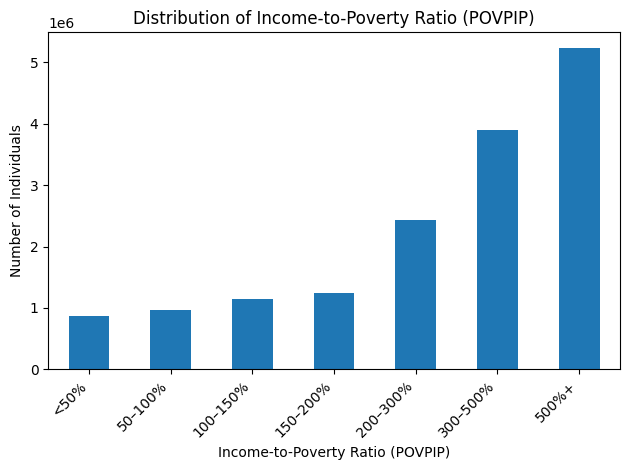

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load only POVPIP (lightweight)
p_file = "../1_Raw_Data/data_persons_us_1yr/psam_pus_master.csv"
df_pov = pd.read_csv(p_file, usecols=["POVPIP"])

# Drop missing values
df_pov = df_pov.dropna()

# Define bins (common in poverty analysis)
bins = [0, 50, 100, 150, 200, 300, 500, df_pov["POVPIP"].max()]
labels = [
    "<50%",
    "50–100%",
    "100–150%",
    "150–200%",
    "200–300%",
    "300–500%",
    "500%+"
]

df_pov["POVPIP_bin"] = pd.cut(df_pov["POVPIP"], bins=bins, labels=labels, include_lowest=True)

# Count per bin
bin_counts = df_pov["POVPIP_bin"].value_counts().sort_index()

# Plot
plt.figure()
bin_counts.plot(kind="bar")
plt.xlabel("Income-to-Poverty Ratio (POVPIP)")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Income-to-Poverty Ratio (POVPIP)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


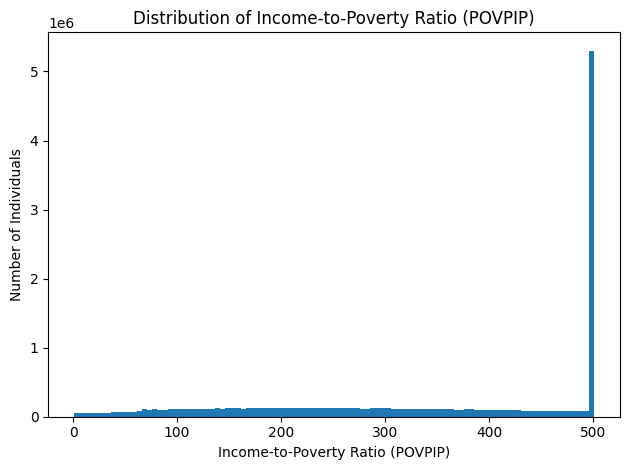

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load only POVPIP (lightweight)
p_file = "../1_Raw_Data/data_persons_us_1yr/psam_pus_master.csv"
df_pov = pd.read_csv(p_file, usecols=["POVPIP"])

# Drop missing and non-positive values
df_pov = df_pov.dropna()
df_pov = df_pov[df_pov["POVPIP"] > 0]

plt.figure()
plt.hist(df_pov["POVPIP"], bins=100)
plt.xlabel("Income-to-Poverty Ratio (POVPIP)")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Income-to-Poverty Ratio (POVPIP)")
plt.tight_layout()
plt.show()


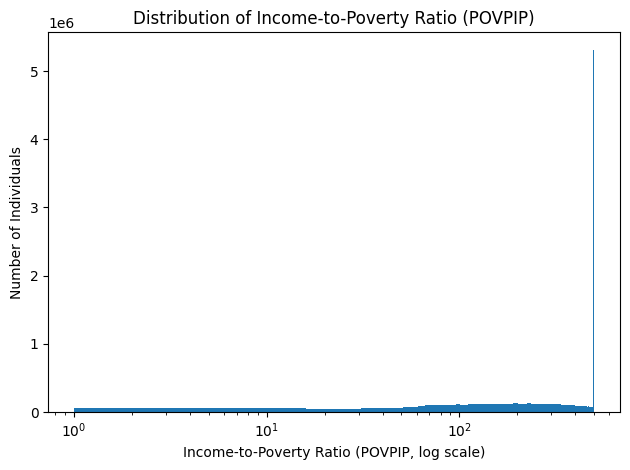

In [13]:
plt.figure()
plt.hist(df_pov["POVPIP"], bins=100)
plt.xscale("log")
plt.xlabel("Income-to-Poverty Ratio (POVPIP, log scale)")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Income-to-Poverty Ratio (POVPIP)")
plt.tight_layout()
plt.show()


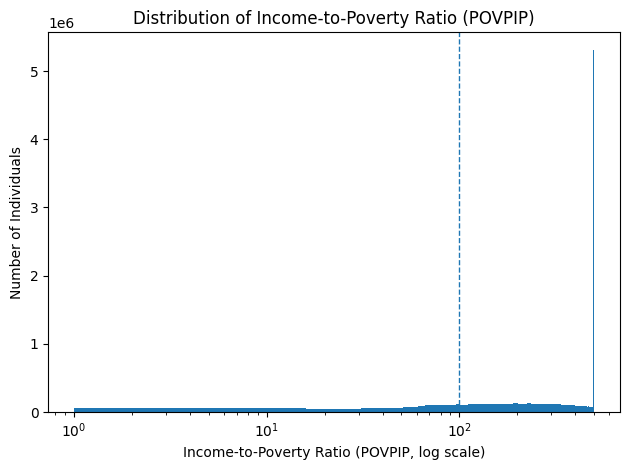

In [14]:
plt.figure()
plt.hist(df_pov["POVPIP"], bins=100)
plt.axvline(100, linestyle="--", linewidth=1)  # poverty threshold
plt.xscale("log")
plt.xlabel("Income-to-Poverty Ratio (POVPIP, log scale)")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Income-to-Poverty Ratio (POVPIP)")
plt.tight_layout()
plt.show()
